# Unit root test and Hurst exponent

Тест на единичный корень и показатель Херста

## Обзор

 - Сначала мы рассмотрим более подробную информацию о некоторых концепциях, которые мы видели в предыдущих лекциях.
 - Затем мы представим новые инструменты аналитики и некоторые из их применений в финансовых приложениях.

Содержание:

    1. Немного теории

    2. Unit root test.

    3. Mean reversion.

    4. Hurst Exponent.

    5. Geometric Brownian motion.
    

In [163]:
# !pip install yfinance

In [164]:
# Imports
import warnings
warnings.simplefilter(action="ignore", category=(FutureWarning, DeprecationWarning))
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
np.random.seed(0)  # For reproducible results

---

## Немного теории

Краткое содержание прошлых лекций

### Декомпозиция

 - Данные временных рядов могут быть разложены на тренд, сезонность и случайные компоненты колебаний.

 **Тренд**
 - Увеличение.
 - Уменьшение.
 - Плоский.
 - Большие тренды могут быть составлены из меньших трендов.
 - Не существует определенного срока для того, что представляет собой тренд: это зависит от ваших данных и задачи.

**Сезонные эффекты**

Примеры
 - В выходные дни розничные продажи.
 - Праздничные покупки.
 - Потребление энергии изменяется с годовыми погодными условиями.

**Случайные колебания**
 - Ошибки наблюдения.
 - Шумы.
 - Непредсказуемые флуктуации

### Аддитивность против мультипликативности

 - Две простые категории моделей временных рядов:

 **Аддитивные**
 - Data = Trend + Seasonal + Random.
 - Если наша сезонность и колебания стабильны, у нас, вероятно, есть аддитивная модель.

**Мультипликативный**
- Data = Trend $\times$ Seasonal $\times$ Random.
- Легко превратить в Аддитивный, если взять логарифм: ``log(Data) = log(Trend) + log(Seasonal) + log(Random)``.
- Используйте мультипликативные модели, если:
  - амплитуда сезонных и случайных колебаний растет вместе с трендом,
  - процентное изменение наших данных важнее, чем изменение абсолютного значения (например, акции, товары).

### Стационарность

Временной ряд является стационарным, если:

- Среднее значение ряда постоянно.
- Дисперсия не меняется со временем (гомоскедастичность).
- Ковариация не является функцией времени.

<img src="data\l6\non-stationarity.png" style="width: 60%; display: block; margin: auto;">

### Обнаружение нестационарности

- Создание графика последовательности запусков.

- Скользящая статистика:
  - Вычислите и начертите скользящую статистику, такую ​​как скользящее среднее/дисперсия, по фрагментам данных.
  - Проверьте, меняется ли статистика со временем.
  - Эту технику можно применять в разных окнах (маленькие окна шумные, большие окна слишком консервативные).

- Расширенный тест Дики-Фуллера (ADF):
    - Статистические тесты для проверки стационарности.
    - Нулевая гипотеза $H_0$ заключается в том, что временной ряд нестационарен.
    - Если статистика теста достаточно мала и $p$-значение ниже целевого $\alpha$, мы _можем_ отвергнуть $H_0$ и сказать, что ряд стационарен.

### Достижение стационарности

- Возьмите логарифм данных.
- Продифференцируйте, вычислив разности  (при необходимости несколько раз), для удаления трендов и сезонности.
- Вычтите предполагаемые трендовые и сезонные компоненты.

## Unit root test

- ADF является одним из самых популярных тестов на единичный корень.
- Наличие единичного корня предполагает, что временной ряд генерируется стохастическим процессом с некоторым уровнем устойчивости.
- Это означает, что потрясения в системе будут иметь постоянные эффекты.
- Это противоположно стационарным процессам, где потрясения имеют только временные эффекты.

> Откуда взялся термин *единичный корень*?

- Рассмотрим простой авторегрессионный процесс порядка 1, обозначаемый как AR(1).
- Это представлено как:

$$Y(t) = \phi Y(t-1) + \epsilon_t,$$

- где
- $Y(t)$ - значение ряда в момент времени $t$,
- $\phi$ - коэффициент,
- $\epsilon_t$ - ошибка белого шума.

- Для анализа свойств AR(1) мы можем переписать его уравнение в терминах **оператора запаздывания** $L$, где $LY(t) = Y(t-1)$.
- Уравнение становится:

$$(1 - \phi L)Y(t) = \epsilon_t$$

- Член $(1 - \phi L)$ известен как **характеристическое уравнение** процесса AR(1).

- Корни этого уравнения находятся путем установки $1 - \phi L = 0$ и решения относительно $L$.
- Решение дает $L = 1/\phi$, что является **корнем характеристического уравнения**.

- Если $\phi = 1$, то $L = 1/\phi = 1$, что означает, что корень характеристического уравнения имеет «единичное» значение.
- Это то, что известно как «единичный корень».
- Когда процесс AR(1) имеет единичный корень (т. е. $\phi = 1$), это означает, что ряд нестационарен, поскольку он становится случайным блужданием: $Y(t) = Y(t-1) + \epsilon_t$
- Значение ряда будет сильно зависеть от его предыдущих значений (шоки в ряде оказывают постоянное влияние).

### Подробнее о тесте ADF

**Формулировка теста**
- Основная идея теста ADF заключается в оценке того, полезны ли запаздывающие значения временного ряда для прогнозирования текущих значений.
- Тест начинается с модели, которая включает временной ряд, запаздывающий на один период (запаздывание-1).
- Затем добавляются другие запаздывающие члены для контроля корреляции более высокого порядка (это «дополненная» часть теста ADF).

**Уравнение теста ADF**

Тест ADF моделирует временной ряд следующим уравнением:

$$\Delta Y(t) = \alpha + \beta t + \gamma Y(t-1) + \sum_{i=1}^{p} \delta_i \Delta_{t-i} + \epsilon_t$$

- где
- $\Delta_t = Y(t) - Y(t-1)$ - разность ряда в момент времени $t$,
- $\alpha$ - константа,
- $\beta$ представляет тренд,
- $\gamma$ - коэффициент при запаздывающем значении ряда,
- члены $\delta_i$ - коэффициенты для запаздывающих разностей (учитывают корреляции более высокого порядка),
- член ошибки $\epsilon_t$.

**Тест ADF для AR(1)**

- Откуда берется модель, используемая в тесте ADF?
- Рассмотрим простой случай модели AR(1):

$$
Y(t) = \phi Y(t-1) + \epsilon_t
$$

- Вычтем $Y(t-1)$ из обеих сторон:

\begin{align*}
Y(t) - Y(t-1) & = \phi Y(t-1) - Y(t-1) + \epsilon_t \\
\Delta Y(t) &= (\phi - 1) Y(t-1) + \epsilon_t
\end{align*}

Это в точности модель ADF выше, когда:
- $p=1$
- $\alpha=\beta=0$ (нулевое среднее и отсутствие тренда)
- $\gamma = \phi - 1$

**Связь с единичным корнем**

- Если $\gamma = 0$, то $\phi = 1$ (единичный корень).
- Это означает, что

$$\Delta Y(t) = \epsilon_t \implies Y(t) = Y(t-1) + \epsilon_t,$$

- что является нестационарным случайным блужданием.

**Нулевая и альтернативная гипотезы (пересмотренные)**
- $H_0$: $\gamma = 0$ временной ряд имеет единичный корень, т. е. он не является стационарным.
- $H_1$: $\gamma < 0$ ряд не имеет единичного корня.

**Тестовая статистика**:
- Тестовая статистика ADF — это коэффициент $\hat{\gamma}$, оцененный по данным.
- Оцененная статистика $\hat{\gamma}$ затем сравнивается с критическими значениями для распределения ADF.
- Если тестовая статистика более отрицательна, чем критическое значение, $H_0$ отклоняется.
- Если тестовая статистика менее отрицательна, чем критическое значение, $H_0$ не может быть отклонена.

- Например, рассмотрим уровень достоверности $\alpha=0,05$.
- Согласно распределению $\gamma$, он соответствует критическому значению $\gamma_\alpha=-2,89$.
- Если тестовая статистика $\hat\gamma$ более отрицательна, чем критическое значение $\gamma_\alpha$, $H_0$ отклоняется.
- Если тестовая статистика $\hat\gamma$ менее отрицательна, чем критическое значение $\gamma_\alpha$, $H_0$ не может быть отклонена.

**Выбор длины лага**:
- Количество лагов ($p$), включенных в тестовое уравнение, имеет важное значение.
- Слишком малое количество лагов может привести к потере необходимых поправок для автокорреляции.
- Слишком большое количество лагов может снизить мощность теста.
- Соответствующая длина лага часто выбирается на основе информационных критериев, таких как информационный критерий Акаике (AIC) или информационный критерий Шварца (BIC).

In [165]:
# Generating a random walk time series (replace this with your dataset)
data = pd.Series(100 + np.random.normal(0, 1, 100).cumsum())

# Perform Augmented Dickey-Fuller test
# the lag can be set manually with 'maxlag' or inferred automatically with autolag
result = adfuller(data, autolag='AIC')  # You can change to 'BIC' for Schwarz Information Criterion

adf_statistic, p_value, usedlag, nobs, critical_values, icbest = result
print(f'ADF Statistic: {adf_statistic :.2f}')
print(f'p-value: {p_value :.2f}')
print(f'Used Lag: {usedlag}')
print(f'Number of Observations: {nobs}')
print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(critical_values.values(), critical_values.keys())]}\n")

ADF Statistic: -1.13
p-value: 0.70
Used Lag: 0
Number of Observations: 99
Critical Values: ['1%: -3.50', '5%: -2.89', '10%: -2.58']



**Типы тестов ADF**
- Существует три версии теста ADF в зависимости от того, включает ли уравнение ни одного, оба или один из терминов $\alpha$ (константа) и $\beta t$ (тренд):
     - Нет константы или тренда (`'n'`).
     - Константа, но нет тренда (`'c'`).
     - И константа, и тренд (`'ct'`).
- Выбор между ними зависит от природы базового временного ряда и от того, что мы хотим протестировать.

In [166]:
# Function to perform ADF test
def perform_adf_test(series, title, regression_type):
    out = adfuller(series, regression=regression_type)
    print(f"Results for {title}:")
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

# 1. No Constant or Trend
series_no_const_no_trend = pd.Series(np.random.normal(0, 1, 200))

# 2. Constant, but No Trend
series_const_no_trend = pd.Series(50 + np.random.normal(0, 1, 200))

# 3. Both Constant and Trend
series_const_trend = pd.Series(50 + np.linspace(0, 20, 200) + np.random.normal(0, 1, 200))

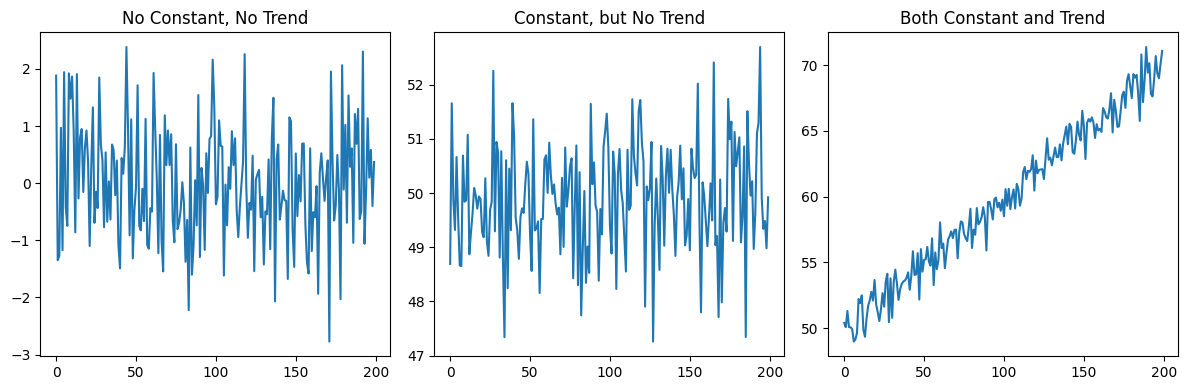

In [167]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
series_no_const_no_trend.plot(title='No Constant, No Trend')
plt.subplot(1, 3, 2)
series_const_no_trend.plot(title='Constant, but No Trend')
plt.subplot(1, 3, 3)
series_const_trend.plot(title='Both Constant and Trend')
plt.tight_layout();

In [168]:
# 1. No Constant or Trend
perform_adf_test(series_no_const_no_trend, "No Constant, No Trend", 'n')

# 2. Constant, but No Trend
perform_adf_test(series_const_no_trend, "Constant, No Trend", 'c')

# 3. Both Constant and Trend
perform_adf_test(series_const_trend, "Constant and Trend", 'ct')

Results for No Constant, No Trend:
ADF Statistic: -15.47
p-value: 0.000
Critical Values: ['1%: -2.58', '5%: -1.94', '10%: -1.62']

Results for Constant, No Trend:
ADF Statistic: -13.95
p-value: 0.000
Critical Values: ['1%: -3.46', '5%: -2.88', '10%: -2.57']

Results for Constant and Trend:
ADF Statistic: -14.68
p-value: 0.000
Critical Values: ['1%: -4.00', '5%: -3.43', '10%: -3.14']



- В последних двух случаях, без учета ненулевого среднего значения и тренда, мы не отвергаем $H_0$.
- Попробуйте использовать ``'n'`` в последних двух примерах и убедитесь сами.

---

## Mean reversion test

- Возврат к среднему значению относится к свойству временного ряда возвращаться к своему историческому среднему значению.
- Эта концепция особенно популярна в финансовой экономике, где часто предполагается, что цены активов и возвращаются к своему историческому среднему значению в долгосрочной перспективе.
- Не существует надлежащего математического определения возврата к среднему значению.

### Применение в финансах

1. **Управление портфелем**
- Инвесторы используют возврат к среднему значению как стратегию покупки активов, которые показали низкую доходность, и продажи активов, которые показали высокую доходность, ожидая, что они вернутся к своему историческому среднему значению.

2. **Управление рисками**
    - Понимание возврата к среднему значению помогает оценить долгосрочный риск активов.
    - Если актив имеет высокую степень возврата к среднему значению, его можно считать менее рискованным в долгосрочной перспективе, поскольку он имеет тенденцию возвращаться к своему среднему значению.

3. **Модели ценообразования**
    - При ценообразовании опционов некоторые модели предполагают возврат к среднему значению волатильности базового актива.
    - Это влияет на ценообразование и стратегию торговли опционами.

4. **Экономическое прогнозирование**
    - Экономические переменные (такие как темпы роста ВВП, процентные ставки) часто демонстрируют возврат к среднему значению.
    - Это предположение используется в макроэкономических моделях и прогнозах.

### Тестирование на возврат к среднему значению
- Определяет, вернется ли временной ряд к этому среднему значению после отклонения от среднего значения.
- Это можно сделать с помощью тестов на единичный корень, таких как ADF.
- Если временной ряд имеет единичный корень, это означает, что он не возвращается к среднему значению.
- Отсутствие единичного корня может указывать на возврат к среднему значению.

**Пример: акции Google**

Мы загрузим данные Google Open-High-Low-Close-Volume (GOOG OHLCV) с 1 сентября 2004 г. по 31 августа 2020 г. из [Yahoo finance](https://finance.yahoo.com/) с помощью пакета Python ``yfinance``.

In [169]:
def get_data(tickerSymbol, period, start, end):

    # Get data on the ticker
    tickerData = yf.Ticker(tickerSymbol)

    # Get the historical prices for this ticker
    tickerDf = tickerData.history(period=period, start=start, end=end)

    return tickerDf

data = get_data('GOOG', period='1d', start='2004-09-01', end='2020-08-31')

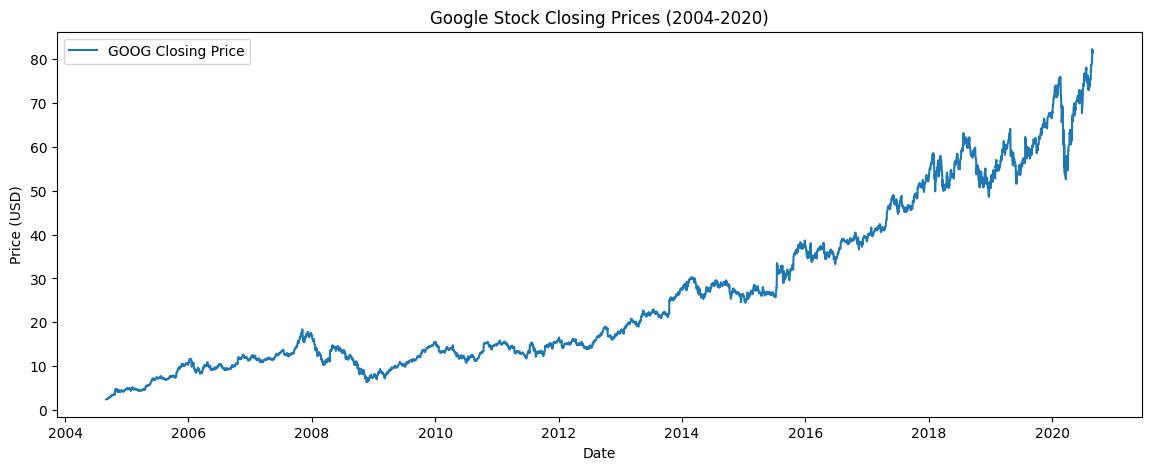

In [170]:
# Plotting the Closing Prices
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='GOOG Closing Price')
plt.title('Google Stock Closing Prices (2004-2020)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

In [171]:
# Perform the ADF test
perform_adf_test(data['Close'],"Google Stock Closing Prices", 'ct')

Results for Google Stock Closing Prices:
ADF Statistic: -0.78
p-value: 0.968
Critical Values: ['1%: -3.96', '5%: -3.41', '10%: -3.13']



- Мы не можем отклонить гипотезу $H_0$.
- Этот ряд не похож на временной ряд, возвращающийся в среднему значению.

### Возврат к среднему значению VS стационарность

Проверка возврата к среднему значению и проверка стационарности — это связанные, но разные концепции в анализе временных рядов.

**Ключевые различия**:
- Проверка возврата к среднему значению фокусируется на том, вернется ли временной ряд к определенному уровню (среднему значению).
- Проверка стационарности проверяет, остаются ли общие статистические свойства ряда неизменными с течением времени.
- Стационарный временной ряд может быть или не быть возвращающимся к среднему значению.
- Стационарный ряд с постоянным средним значением и дисперсией с течением времени может все еще не вернуться к своему среднему значению после шока.
- И наоборот, ряд с возвратом к среднему значению должен иметь некоторую стационарность, особенно в своем среднем значении, но он все еще может иметь изменяющуюся дисперсию или другие свойства с течением времени.

## Экспонента Херства, Показатель Херста

- Показатель Херста ($H$) - это мера, используемая для характеристики долговременной памяти временных рядов.
- Он помогает определить наличие автокорреляции или постоянства в данных.
- Цель показателя Херста - предоставить нам скалярное значение, которое поможет нам определить, является ли ряд
    - случайным блужданием,
    - трендовым,
    - возвратом к среднему.

- Ключевое понимание заключается в том, что если существует какая-либо *автокорреляция*, то

$$\text{Var}(X(t + \tau) - X(t)) \propto \tau^{2H}$$

- где $H$ - показатель Херста.

Временной ряд можно охарактеризовать следующим образом:

- Если $H = 0,5$, временной ряд похож на случайное блуждание. В этом случае дисперсия увеличивается линейно с $\tau$.
- Если $H < 0,5$, временной ряд демонстрирует антиперсистентность, т. е. возврат к среднему. Дисперсия увеличивается медленнее, чем линейно с $\tau$.
- Если $H > 0,5$, временной ряд демонстрирует устойчивую долгосрочную зависимость, т. е. является трендовым. Дисперсия увеличивается быстрее, чем линейно с $\tau$.

In [172]:
def hurst(ts):

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.var(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]/2.0

**Как выглядят постоянные и антипостоянные временные ряды?**

- Давайте создадим скрипт Python (адаптированный отсюда](https://github.com/Mottl/hurst/tree/master)) для генерации случайного блуждания с сохранением.
- Мы должны включить форму «памяти», рассматривая прошлые значения в указанном окне просмотра, чтобы определить направление следующего шага.

Давайте определим

```python
def random_walk_memory(length, proba, min_lookback, max_lookback)
```

где:
- ``proba`` - вероятность того, что следующий шаг будет следовать тренду.
    - proba > 0,5 постоянный случайный блуждание
    - proba < 0,5 антиперсистентный

- ``min_lookback`` и ``max_lookback`` - минимальный и максимальный размеры окна для расчета направления тренда

In [173]:
def random_walk_memory(length, proba=0.5, min_lookback=1, max_lookback=100):
    series = [0.] * length
    for i in range(1, length):

        # If the series has not yet reached the min_lookback threshold
        # the direction of the step is random (-1 or 1)
        if i < min_lookback + 1:
            direction = np.sign(np.random.randn())

        # consider the historical values to determine the direction
        else:
            # randomly choose between min_lookback and the minimum of
            # i-1 (to ensure not exceeding the current length) and max_lookback.
            lookback = np.random.randint(min_lookback, min(i-1, max_lookback)+1)

            # Decides whether to follow the recent trend or move against it,
            # based on a comparison between proba and a random number between 0 and 1.
            recent_trend = np.sign(series[i-1] - series[i-1-lookback])
            change = np.sign(proba - np.random.uniform())
            direction = recent_trend * change

        series[i] = series[i-1] + np.fabs(np.random.randn()) * direction
    return series

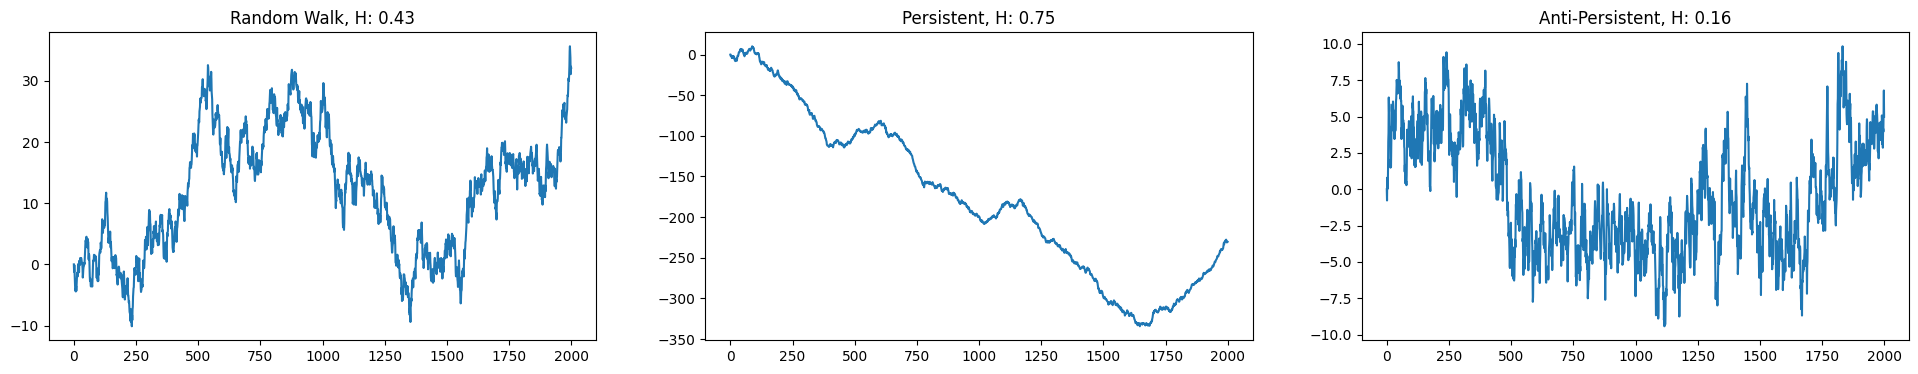

In [174]:
bm = random_walk_memory(2000, proba=0.5)
persistent = random_walk_memory(2000, proba=0.7)
antipersistent = random_walk_memory(2000, proba=0.3)

_, axes = plt.subplots(1,3, figsize=(24, 4))
axes[0].plot(bm)
axes[0].set_title(f"Random Walk, H: {hurst(bm):.2f}")
axes[1].plot(persistent)
axes[1].set_title(f"Persistent, H: {hurst(persistent):.2f}")
axes[2].plot(antipersistent)
axes[2].set_title(f"Anti-Persistent, H: {hurst(antipersistent):.2f}");

- Каков показатель Херста цены закрытия акций Google?

In [175]:
print(f"GOOG closing price, H: {hurst(data['Close'].values):.2f}")

GOOG closing price, H: 0.41


- Временной ряд акций Google приближается к $H=0,5$, что указывает на то, что он близок к геометрическому случайному блужданию (по крайней мере, для рассматриваемого нами периода выборки).
- Что это означает на практике?

### Интерпретация показателя Херста в финансах:

- Показатель Херста, $H$, является важнейшей метрикой в ​​анализе финансовых временных рядов.
- Дает представление о поведении активов, таких как акции.
- Вот как интерпретировать $H$ в контексте *заключительных цен акций* и его влияния на *инвестиционные решения*.

**Случай 1: $H = 0,5$**

- Это значение предполагает, что цена акций следует случайному блужданию.
- Это подразумевает, что будущие движения цен не зависят от прошлых движений.
- Для инвесторов это означает, что в движениях цен нет автокорреляций, которые можно было бы использовать; прошлые данные не могут предсказать будущие цены.
- Торговые стратегии, основанные на исторических ценовых моделях или тенденциях, теоретически не более успешны, чем случайные угадывания.
- Инвесторам следует полагаться на более широкий анализ рынка или стратегии диверсифицированного портфеля, а не пытаться предсказать будущие цены на основе прошлых тенденций.

**Случай 2: $H < 0,5$**

- Указывает на серию возврата к среднему значению, т. е. цена акций имеет тенденцию возвращаться к своему историческому среднему значению.
- Это говорит о том, что актив менее рискован в долгосрочной перспективе.
- Инвесторы могут интерпретировать низкий $H$ как возможность купить акции после значительного падения, ожидая возврата к среднему значению, или продать после существенного роста.

**Случай 3: $H > 0,5$**

- Предполагает трендовую серию, где рост или падение цен на акции, вероятно, будут сопровождаться дальнейшим ростом или падением соответственно.
- Эта устойчивость указывает на потенциальный импульс цен на акции, который можно использовать с помощью стратегий импульса:
- Покупка акций, которые растут, в надежде, что они продолжат расти, и продажа тех, которые растут в нисходящем тренде.

#### Практические соображения:

Прежде чем применять эти интерпретации, инвесторам следует также учесть следующие соображения:
- Наблюдаемое значение $H$ может меняться в разных временных рамках: проанализируйте $H$ за период, соответствующий инвестиционному горизонту.
- Внешние факторы, такие как рыночные условия, экономические показатели и геополитические события, могут влиять на цены акций и должны рассматриваться наряду с $H$.
- Независимо от значения $H$, реализация надлежащих стратегий управления рисками имеет важное значение для защиты от неожиданных движений рынка.
- Если временной ряд слишком короткий, значение $H$ может быть ненадежным.

---

## Броуновское движение

- Вспомним случайное блуждание

$$X(t) = X(t-1) + \epsilon_t$$

- где $\epsilon_t \sim \mathcal{N}(0,\sigma^2)$.

- Это также можно выразить как:

$$X(t) = X(0) + W(t)$$

- где $W(t)$ называется *Винеровским процессом*, или как:

$$X(t) = X(0) + B(t)$$

- где $B(t)$ называется *Броуновским движением*.
- $W(t)$ и $B(t)$ представляют собой кумулятивную сумму нормально распределенных приращений $\epsilon_1 + \epsilon_2 + \dots \epsilon_t$.

**Дисперсия броуновского движения при задержке $\tau$**

- Для временного ряда $X(t)$ дисперсия при задержке $\tau$ может быть определена как:

$$\text{Var}(X(t + \tau) - X(t))$$

- Если $B(t)$ рассматривается как броуновское движение, то приращение $B(t + \tau) - B(t)$ нормально распределено со средним значением 0 и дисперсией $\tau$.
- Это происходит потому, что дисперсия приращений броуновского движения за период $\tau$ равна $\tau$.

$$\text{Var}(B(t + \tau) - B(t)) = \tau$$

---

## Геометрическое броуновское движение

- *Геометрическое броуновское движение* (GBM) — это стохастический процесс.
- Его часто используют для моделирования цен акций и других финансовых переменных, которые не возвращаются к среднему значению, а скорее демонстрируют тенденции с дрейфом $\mu$ и волатильностью $\sigma$.

GBM определяется как:

$$S(t) = S_0 \exp\left((\mu - \frac{1}{2} \sigma^2)t + \sigma W(t)\right)$$

- где
    - $S(t)$ - цена акций в момент времени $t$.
    - $S_0$ - начальная цена акций в момент времени $t = 0$.
    - $\mu$ - ожидаемая годовая доходность (коэффициент дрейфа).
    - $\sigma$ - волатильность (стандартное отклонение доходности).
    - $W(t)$ - винеровский процесс (стандартное броуновское движение).

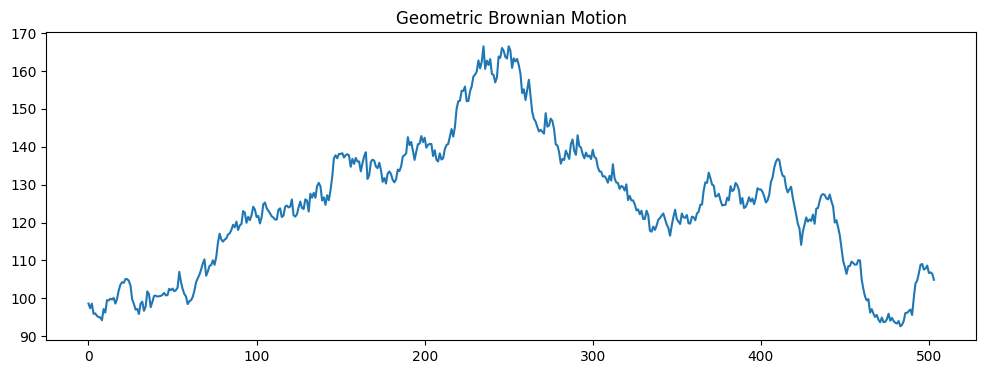

In [176]:
S0 = 100                 # Initial stock price
mu = 0.09                # Expected annual return (9%)
sigma = 0.25             # Annual volatility (25%)
T = 2                    # Time horizon in years
dt = 1/252               # Time step in years, assuming 252 trading days per year
N = int(T/dt)            # Number of time steps
t = np.linspace(0, T, N) # Time vector

# Brownian Motion
dW = np.random.normal(0, np.sqrt(dt), N)
W = np.cumsum(dW)

# Geometric Brownian Motion
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(12, 4))
plt.plot(S)
plt.title('Geometric Brownian Motion');

### Дисперсия GBM

- Во-первых, обратите внимание, что $S(t)$ распределен *логарифмически нормально*, поскольку является экспоненциальной функцией нормально распределенного процесса $B(t)$.
- Дисперсию $S(t)$ можно найти из свойств логарифмически нормального распределения:

$$\text{Var}(S(t)) = \left(e^{\sigma^2 t} - 1\right) e^{2\mu t + \sigma^2 t} S_0^2.$$

- Это показывает, что дисперсия GBM не линейна по $t$, как у BM.
- Вместо этого она растет *экспоненциально* со временем из-за экспоненциального члена $e^{\sigma^2 t}$.
- Это, а также возможность дрейфа моделирования (ожидаемая годовая доходность) являются основными дополнениями GBM по сравнению с BM.

### Реальные приложения

- GBM можно использовать для моделирования реальных цен акций и имитации их будущего поведения.
- Сначала мы оцениваем $\mu$ и $\sigma$ на основе исторических данных о ценах акций.
    - $\mu$ может быть историческим средним значением логарифмической доходности акций.
    - $\sigma$ может быть стандартным отклонением этой доходности.
    - Затем мы используем эти оценки в формуле GBM для имитации будущих ценовых траекторий.

- Этот метод широко используется для ценообразования опционов, управления рисками и моделирования инвестиционных стратегий.
- Однако GBM имеет ограничения, такие как предположение о *постоянном дрейфе и волатильности*.
- Эти предположения могут не соответствовать действительности на реальных рынках.
- Поэтому его часто используют как компонент более широкого анализа или стратегии моделирования.

In [177]:
# Step 1: Get the "training" data (e.g., 2020-2022)
data2 = get_data('GOOG', period='1d', start='2019-12-31', end='2022-12-31')


In [178]:
# Get "test" data, for comparison (e.g., 2023)
data3 = get_data('GOOG', period='1d', start='2022-12-31', end='2023-12-31')
test_days = len(data3)

In [179]:
# Step 2: Calculate Daily Returns
returns = data2['Close'].pct_change() # We are interested in the returns, so we get the changes in %

In [180]:
# Step 3: Estimate Parameters for GBM
mu = returns.mean() * 252  # Annualize the mean
sigma = returns.std() * np.sqrt(252)  # Annualize the std deviation

In [181]:
# Step 4: Set GBM parameters
T = 1  # Time horizon in years
dt = 1/test_days  # Time step in years, assuming 252 trading days per year
N = int(T/dt)  # Number of time steps
time_step = np.linspace(0, T, N)
S0 = data2['Close'].iloc[-1]  # Starting stock price (latest close price)

In [182]:
#  Step 5: Compute Simulation
W = np.random.standard_normal(size=N)
W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum for the Wiener process
X = (mu - 0.5 * sigma**2) * time_step + sigma * W
S = S0 * np.exp(X)  # GBM formula

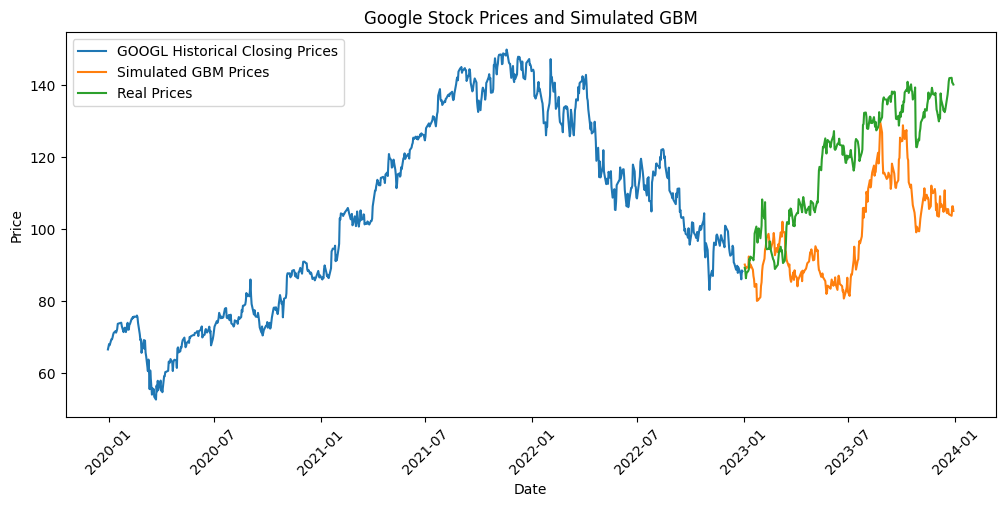

In [183]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(data2['Close'], label='GOOGL Historical Closing Prices')
plt.plot(data3.index, S, label='Simulated GBM Prices')
plt.plot(data3['Close'], label='Real Prices')
plt.legend()
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

- В каждой реализации GBM присутствует стохастический компонент.
- Обычно моделируется больше путей, чтобы получить более информативную симуляцию.

In [184]:
# Simulate multiple paths
n_paths = 10
paths = []
for _ in range(n_paths):
    W = np.cumsum(np.random.standard_normal(size=N))*np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * time_step + sigma * W
    paths.append(S0 * np.exp(X))

path_mean = np.array(paths).mean(axis=0)
path_std = np.array(paths).std(axis=0)

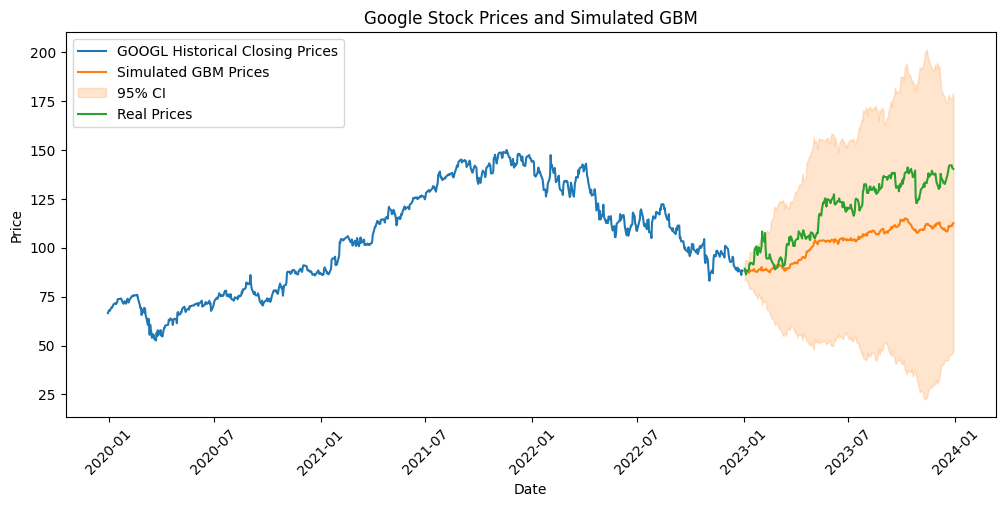

In [185]:
plt.figure(figsize=(12, 5))
plt.plot(data2['Close'], label='GOOGL Historical Closing Prices')
plt.plot(data3.index, path_mean, label='Simulated GBM Prices')
plt.fill_between(data3.index, path_mean-1.96*path_std, path_mean+1.96*path_std, color='tab:orange', alpha=0.2, label='95% CI')
plt.plot(data3['Close'], label='Real Prices')
plt.legend(loc='upper left')
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

---

## Резюме

В этой лекции мы рассмотрели:
1. Тест на единичный корень и более глубокое понимание теста ADF.
2. Возврат к среднему и как его проверить с помощью ADF.
3. Показатель Херста: как его вычислить и его применение в финансах.
4. Геометрическое броуновское движение: определение и применение для моделирования акций.

In [186]:
data_Tesla = get_data('TSLA', period='1d', start='2019-12-31', end='2022-12-31')
data_Equinor = get_data('EQNR', period='1d', start='2019-12-31', end='2022-12-31')

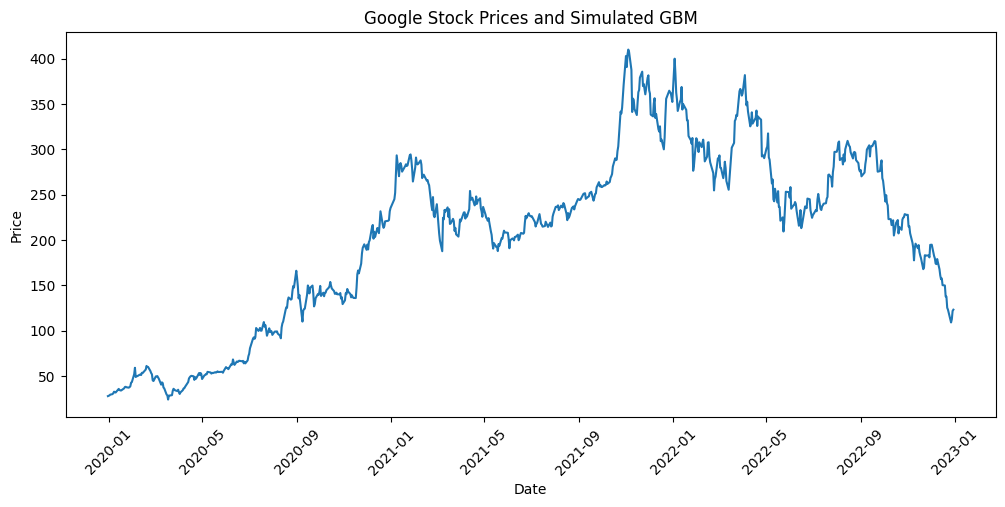

In [187]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(data_Tesla['Close'], label='GOOGL Historical Closing Prices')
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

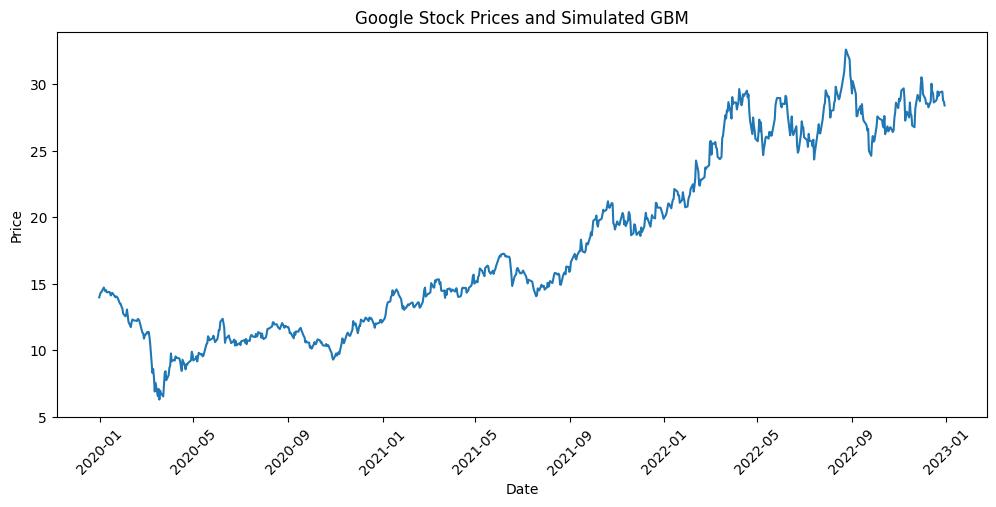

In [188]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(data_Equinor['Close'], label='GOOGL Historical Closing Prices')
plt.title('Google Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

In [189]:
# Perform the ADF test
perform_adf_test(data_Tesla['Close'],"Google Stock Closing Prices", 'ct')
perform_adf_test(data_Equinor['Close'],"Google Stock Closing Prices", 'ct')

Results for Google Stock Closing Prices:
ADF Statistic: -0.93
p-value: 0.953
Critical Values: ['1%: -3.97', '5%: -3.42', '10%: -3.13']

Results for Google Stock Closing Prices:
ADF Statistic: -3.60
p-value: 0.030
Critical Values: ['1%: -3.97', '5%: -3.42', '10%: -3.13']



В датасете с Tesla получается ряд нестационарный, а ряд Equinor считается стационарным, ведь он имеет тренд

In [190]:
print(hurst(np.array((data_Tesla))))

0.04226738563610277


In [191]:
  print(hurst(np.array((data_Equinor))))

0.06316138927059484


In [192]:
mu_TS = data_Tesla.mean()
mu_EQ = data_Equinor.mean()

In [193]:
print("Mean Telsa: ", mu_TS, "| Tesla current: ", data_Tesla['Close'][-1])
print("Mean Equinor: ", mu_EQ, "| Equinor current: ", data_Equinor['Close'][-1])

Mean Telsa:  Open            2.063579e+02
High            2.111669e+02
Low             2.009905e+02
Close           2.061297e+02
Volume          1.318918e+08
Dividends       0.000000e+00
Stock Splits    1.056803e-02
dtype: float64 | Tesla current:  123.18000030517578
Mean Equinor:  Open            1.804651e+01
High            1.825293e+01
Low             1.782496e+01
Close           1.804231e+01
Volume          3.599214e+06
Dividends       3.896962e-03
Stock Splits    0.000000e+00
dtype: float64 | Equinor current:  28.41675567626953


Для обоих датасетов показатели Херста очень маленькие и равны < 0.5, получается что в долгосрочной перспективе акции должны вернутся к своему историческому среднему значению и они менее рискованы для долгосрочных влажений.

В данный момент лучше купить акции Tesla, ведь в скором времени они будут расти, а акции Equinor, стоит продать, ведь они дороже чем их средняя цена.

In [218]:
# Step 1: Get the "training" data (e.g., 2020-2022)
dataTesla_train = get_data('TSLA', period='1d', start='2019-12-31', end='2022-05-01')
# dataEquinor_train = get_data('EQNR', period='1d', start='2019-12-31', end='2022-05-01')

In [219]:
# Get "test" data, for comparison (e.g., 2023)
dataTesla_test = get_data('TSLA', period='1d', start='2022-05-01', end='2022-12-31')
test_days_Tesla = len(dataTesla_test)



In [220]:
# Step 2: Calculate Daily Returns
returns = dataTesla_train['Close'].pct_change() # We are interested in the returns, so we get the changes in %
#

In [221]:
# Step 3: Estimate Parameters for GBM
mu = returns.mean() * 252  # Annualize the mean
sigma = returns.std() * np.sqrt(252)  # Annualize the std deviation

print(mu)
print(sigma)

1.2779641354602527
0.7366552069166887


In [222]:
# Tesla
# Step 4: Set GBM parameters
T = 1  # Time horizon in years
dt = 1/test_days_Tesla  # Time step in years, assuming 252 trading days per year
N = int(T/dt)  # Number of time steps
time_step = np.linspace(0, T, N)
S0 = dataTesla_train['Close'].iloc[-1]  # Starting stock price (latest close price)

In [236]:
#  Step 5: Compute Simulation
W = np.random.standard_normal(size=N)
W = np.cumsum(W)*np.sqrt(dt)  # Cumulative sum for the Wiener process
X = (mu - 0.5 * sigma**2) * time_step + sigma * W
S = S0 * np.exp(X)  # GBM formula

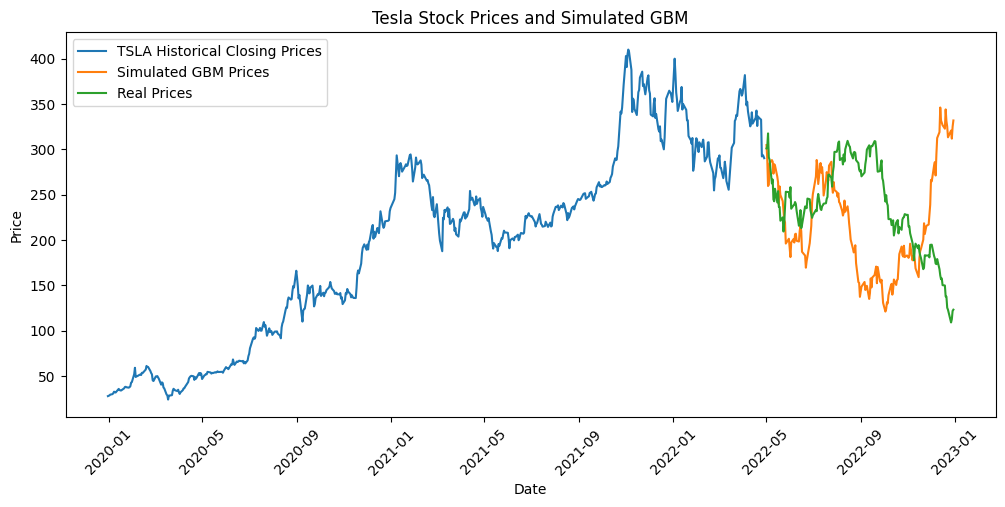

In [237]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(dataTesla_train['Close'], label='TSLA Historical Closing Prices')
plt.plot(dataTesla_test.index, S, label='Simulated GBM Prices')
plt.plot(dataTesla_test['Close'], label='Real Prices')
plt.legend()
plt.title('Tesla Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

In [201]:
dataEquinor_train = get_data('EQNR', period='1d', start='2019-12-31', end='2022-05-01')

In [202]:
dataEquinor_test = get_data('EQNR', period='1d', start='2022-05-01', end='2022-12-31')
test_days_Equinor = len(dataEquinor_test)

In [203]:
returns_Equinor = dataEquinor_train['Close'].pct_change()

In [204]:
mu_EQ = returns_Equinor.mean() * 252  # Annualize the mean
sigma_EQ = returns_Equinor.std() * np.sqrt(252)  # Annualize the std deviation

In [205]:
# Equinor
T_EQ = 1  # Time horizon in years
dt_EQ = 1/test_days_Equinor  # Time step in years, assuming 252 trading days per year
N_EQ = int(T_EQ/dt_EQ)  # Number of time steps
time_step_EQ = np.linspace(0, T_EQ, N_EQ)
S1 = dataEquinor_train['Close'].iloc[-1]  # Starting stock price (latest close price)

In [206]:
W1 = np.random.standard_normal(size=N_EQ)
W1 = np.cumsum(W1)*np.sqrt(dt_EQ)  # Cumulative sum for the Wiener process
X1 = (mu_EQ - 0.5 * sigma_EQ**2) * time_step_EQ + sigma_EQ * W1
S2 = S1 * np.exp(X1)  # GBM formula

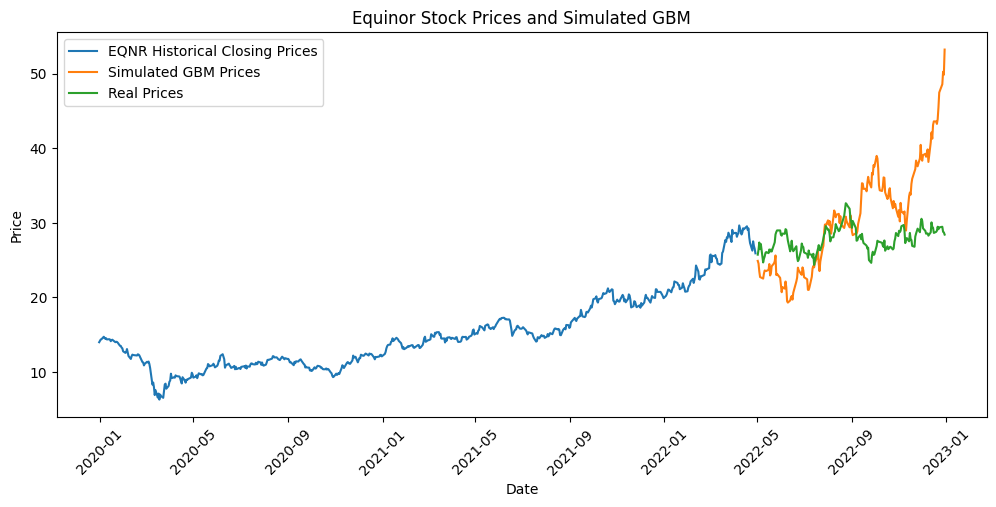

In [207]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.plot(dataEquinor_train['Close'], label='EQNR Historical Closing Prices')
plt.plot(dataEquinor_test.index, S2, label='Simulated GBM Prices')
plt.plot(dataEquinor_test['Close'], label='Real Prices')
plt.legend()
plt.title('Equinor Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

Тут делаем симуляцию 100 раз для Tesla

In [208]:
# Simulate multiple paths
n_paths = 100
paths = []
for _ in range(n_paths):
    W = np.cumsum(np.random.standard_normal(size=N))*np.sqrt(dt)
    X = (mu - 0.5 * sigma**2) * time_step + sigma * W
    paths.append(S0 * np.exp(X))

path_mean_Tesla = np.array(paths).mean(axis=0)
path_std_Tesla = np.array(paths).std(axis=0)

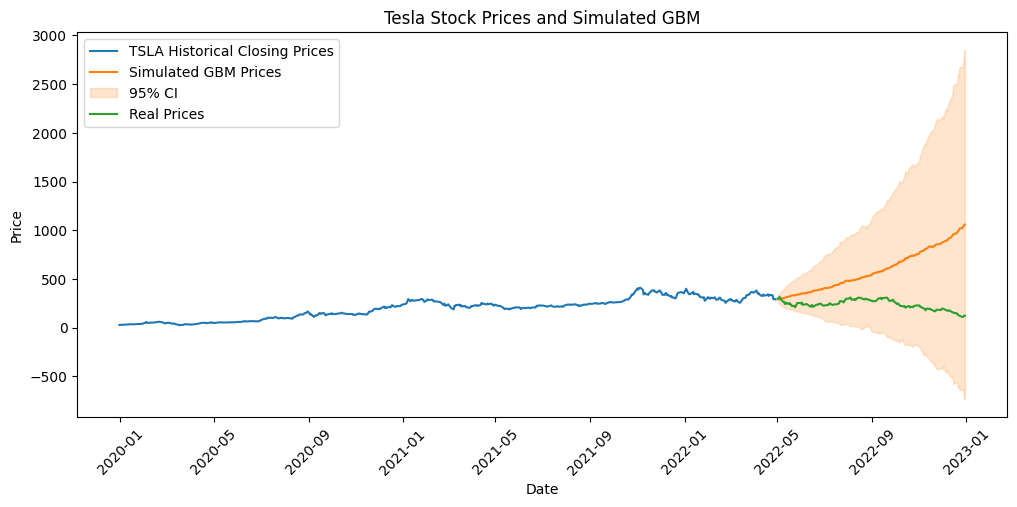

In [209]:
plt.figure(figsize=(12, 5))
plt.plot(dataTesla_train['Close'], label='TSLA Historical Closing Prices')
plt.plot(dataTesla_test.index, path_mean_Tesla, label='Simulated GBM Prices')
plt.fill_between(dataTesla_test.index, path_mean_Tesla-1.96*path_std_Tesla, path_mean_Tesla+1.96*path_std_Tesla, color='tab:orange', alpha=0.2, label='95% CI')
plt.plot(dataTesla_test['Close'], label='Real Prices')
plt.legend(loc='upper left')
plt.title('Tesla Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

Тут делаем симуляцию 100 раз для Equinor

In [210]:
# Simulate multiple paths
n_paths = 100
paths = []
for _ in range(n_paths):
    W1 = np.cumsum(np.random.standard_normal(size=N_EQ))*np.sqrt(dt_EQ)
    X1 = (mu_EQ - 0.5 * sigma_EQ**2) * time_step_EQ + sigma_EQ * W1
    paths.append(S1 * np.exp(X1))

path_mean_Equinor = np.array(paths).mean(axis=0)
path_std_Equinor = np.array(paths).std(axis=0)

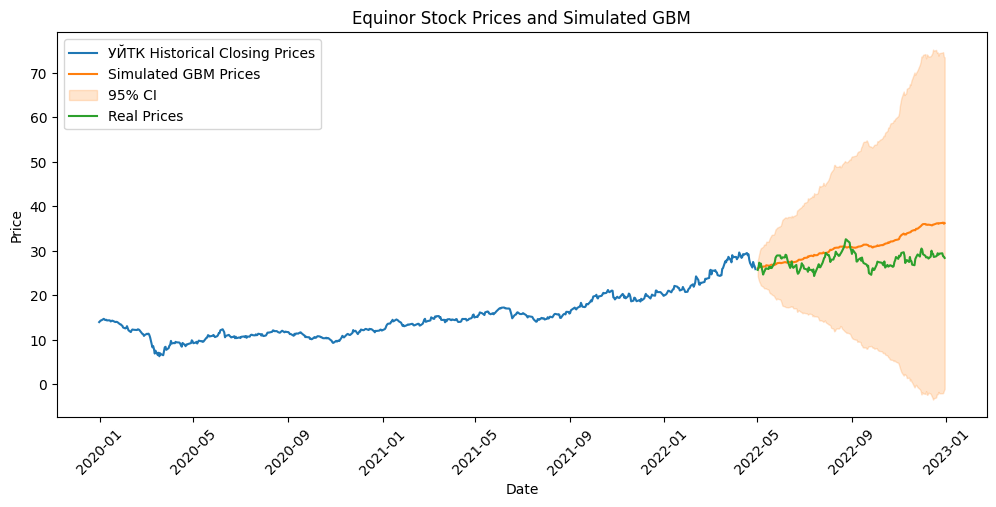

In [211]:
plt.figure(figsize=(12, 5))
plt.plot(dataEquinor_train['Close'], label='УЙТК Historical Closing Prices')
plt.plot(dataEquinor_test.index, path_mean_Equinor, label='Simulated GBM Prices')
plt.fill_between(dataEquinor_test.index, path_mean_Equinor-1.96*path_std_Equinor, path_mean_Equinor+1.96*path_std_Equinor, color='tab:orange', alpha=0.2, label='95% CI')
plt.plot(dataEquinor_test['Close'], label='Real Prices')
plt.legend(loc='upper left')
plt.title('Equinor Stock Prices and Simulated GBM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45);

Вычисление MSE у Tesla и Equinor, между истинными и смоделированными ценами акций

In [212]:
MSE_Tesla = (np.sum((dataTesla_test['Close']-path_mean_Tesla)**2))/test_days_Tesla
MSE_Equinor = (np.sum((dataEquinor_test['Close']-path_mean_Equinor)**2))/test_days_Equinor

In [213]:
print("MSE Tesla: ",MSE_Tesla)

MSE Tesla:  185936.02068260184


In [214]:
print("MSE Equinor: ",MSE_Equinor)

MSE Equinor:  16.861821536078306


По MSE в ряду Tesla составила ошибка 185936, а в Equinor = 16

Сравнение ожижаемое значение MAPE для двух акций

In [215]:
MAPE_Tesla = (np.sum(np.abs(dataTesla_test['Close']-path_mean_Tesla)/np.abs(dataTesla_test['Close'])))/test_days_Tesla * 100
MAPE_Equinor = (np.sum(np.abs(dataEquinor_test['Close']-path_mean_Equinor)/np.abs(dataEquinor_test['Close'])))/test_days_Equinor * 100

In [216]:
print("MAPE Tesla: ",MAPE_Tesla)

MAPE Tesla:  179.9515441135856


In [217]:
print("MAPE Equinor: ",MAPE_Equinor)

MAPE Equinor:  12.26106735647245


По MAPE в ряду Tesla составила ошибка 180%, а в Equinor = 12%

## Упражнение

- Загрузите и нанесите на график исторические цены закрытия Tesla (``TSLA``) и Equinor (``EQNR``) за годы ``2019-12-31``- ``2022-12-31``.
- Для каждого временного ряда:
    - Проверьте, выглядит ли временной ряд стационарным.
    - Вычислите коэффициент Херста для обоих временных рядов.
    - В какие акции вы хотели бы инвестировать? Обоснуйте свой ответ на основе тестов и значения $H$.
    - Смоделируйте цены акций с помощью GBM.

- Какая симуляция кажется более надежной? Для Tesla или Equinor?
- Чтобы обосновать свой ответ:
1. вычислите симуляцию не менее 100 раз.
2. Вычислите MSE между истинными ценами акций и смоделированными.
3. Сравните ожидаемое значение MAPE для двух акций.